In [355]:
%matplotlib nbagg
%load_ext autoreload
%load_ext line_profiler

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse

In [3]:
data = np.zeros((64, 64))
cropped_data = np.linspace(0, 1, 32*32).reshape((32, 32))
cropped_data[3, :] = 2
cropped_data[:, 7] = 3
data[16:16+32, 16:16+32] = cropped_data

<IPython.core.display.Javascript object>


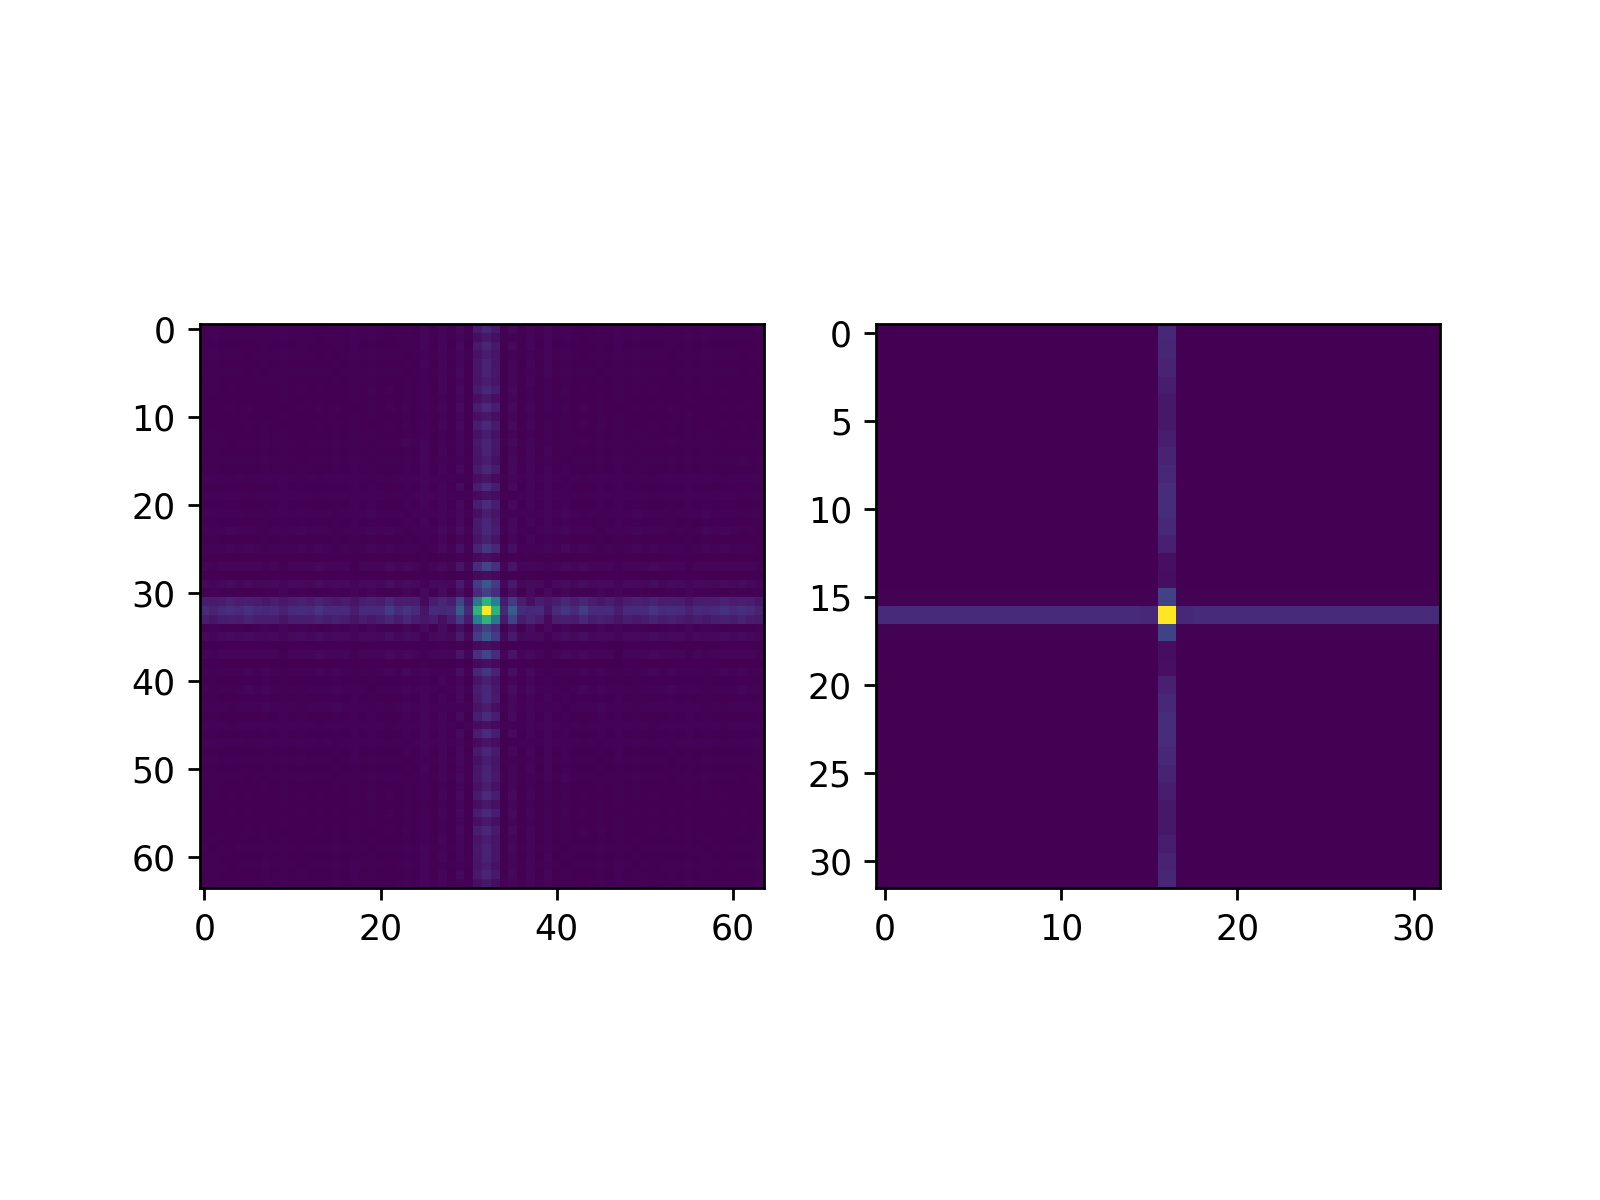

In [4]:
fig, axes, = plt.subplots(1, 2)
axes[0].imshow(np.abs(np.fft.fftshift(np.fft.fft2(data))))
axes[1].imshow(np.abs(np.fft.fftshift(np.fft.fft2(cropped_data))))

In [5]:
np.stack(np.mgrid[:23, :17], axis=2).reshape((23*17, 2))

array([[ 0,  0],
       [ 0,  1],
       [ 0,  2],
       [ 0,  3],
       [ 0,  4],
       [ 0,  5],
       [ 0,  6],
       [ 0,  7],
       [ 0,  8],
       [ 0,  9],
       [ 0, 10],
       [ 0, 11],
       [ 0, 12],
       [ 0, 13],
       [ 0, 14],
       [ 0, 15],
       [ 0, 16],
       [ 1,  0],
       [ 1,  1],
       [ 1,  2],
       [ 1,  3],
       [ 1,  4],
       [ 1,  5],
       [ 1,  6],
       [ 1,  7],
       [ 1,  8],
       [ 1,  9],
       [ 1, 10],
       [ 1, 11],
       [ 1, 12],
       [ 1, 13],
       [ 1, 14],
       [ 1, 15],
       [ 1, 16],
       [ 2,  0],
       [ 2,  1],
       [ 2,  2],
       [ 2,  3],
       [ 2,  4],
       [ 2,  5],
       [ 2,  6],
       [ 2,  7],
       [ 2,  8],
       [ 2,  9],
       [ 2, 10],
       [ 2, 11],
       [ 2, 12],
       [ 2, 13],
       [ 2, 14],
       [ 2, 15],
       [ 2, 16],
       [ 3,  0],
       [ 3,  1],
       [ 3,  2],
       [ 3,  3],
       [ 3,  4],
       [ 3,  5],
       [ 3,  6],
       [ 3,  7

In [6]:
a = np.array((1, 2, 3))

~((a > 1) & (a < 3))

array([ True, False,  True])

In [7]:
d = {}
d.values()

dict_values([])

In [855]:
%autoreload
import scipy.ndimage
import functools

from ptychography40.reconstruction.common import (
    diffraction_to_detector, wavelength,
    image_transformation_matrix, apply_matrix, fftshift_coords, ifftshift_coords
)
from libertem.corrections.coordinates import rotate_deg, flip_y
import libertem.api as lt
from libertem.executor.inline import InlineJobExecutor

In [836]:
source_shape = (6, 6)
target_shape = (6, 6)

In [837]:
# %lprun -f image_transformation_matrix image_transformation_matrix((1024, 1024), (256, 256), lambda x: x*4)

In [846]:
f = functools.partial(
    diffraction_to_detector,
    lamb=1,
    diffraction_shape=target_shape,
    pixel_size_real=1,
    pixel_size_detector=1/np.array(target_shape),
    cy=source_shape[0] / 2,
    cx=source_shape[1] / 2,
    flip_y=False,
    scan_rotation=90.
)

In [847]:
%autoreload
mat = image_transformation_matrix(
    source_shape=source_shape,
    target_shape=target_shape,
    affine_transformation=f,
)

In [848]:
data = np.linspace(0, 1, 4*np.prod(source_shape)).reshape((2, 2) + source_shape)
data[0, 0, 0, 0] = 1
data[0, 1, 0, -1] = 1
data[1, 1, -1, -1] = 1
data[1, 0, -1, 0] = 1

In [849]:
%autoreload
res = apply_matrix(data, mat, target_shape)

<IPython.core.display.Javascript object>


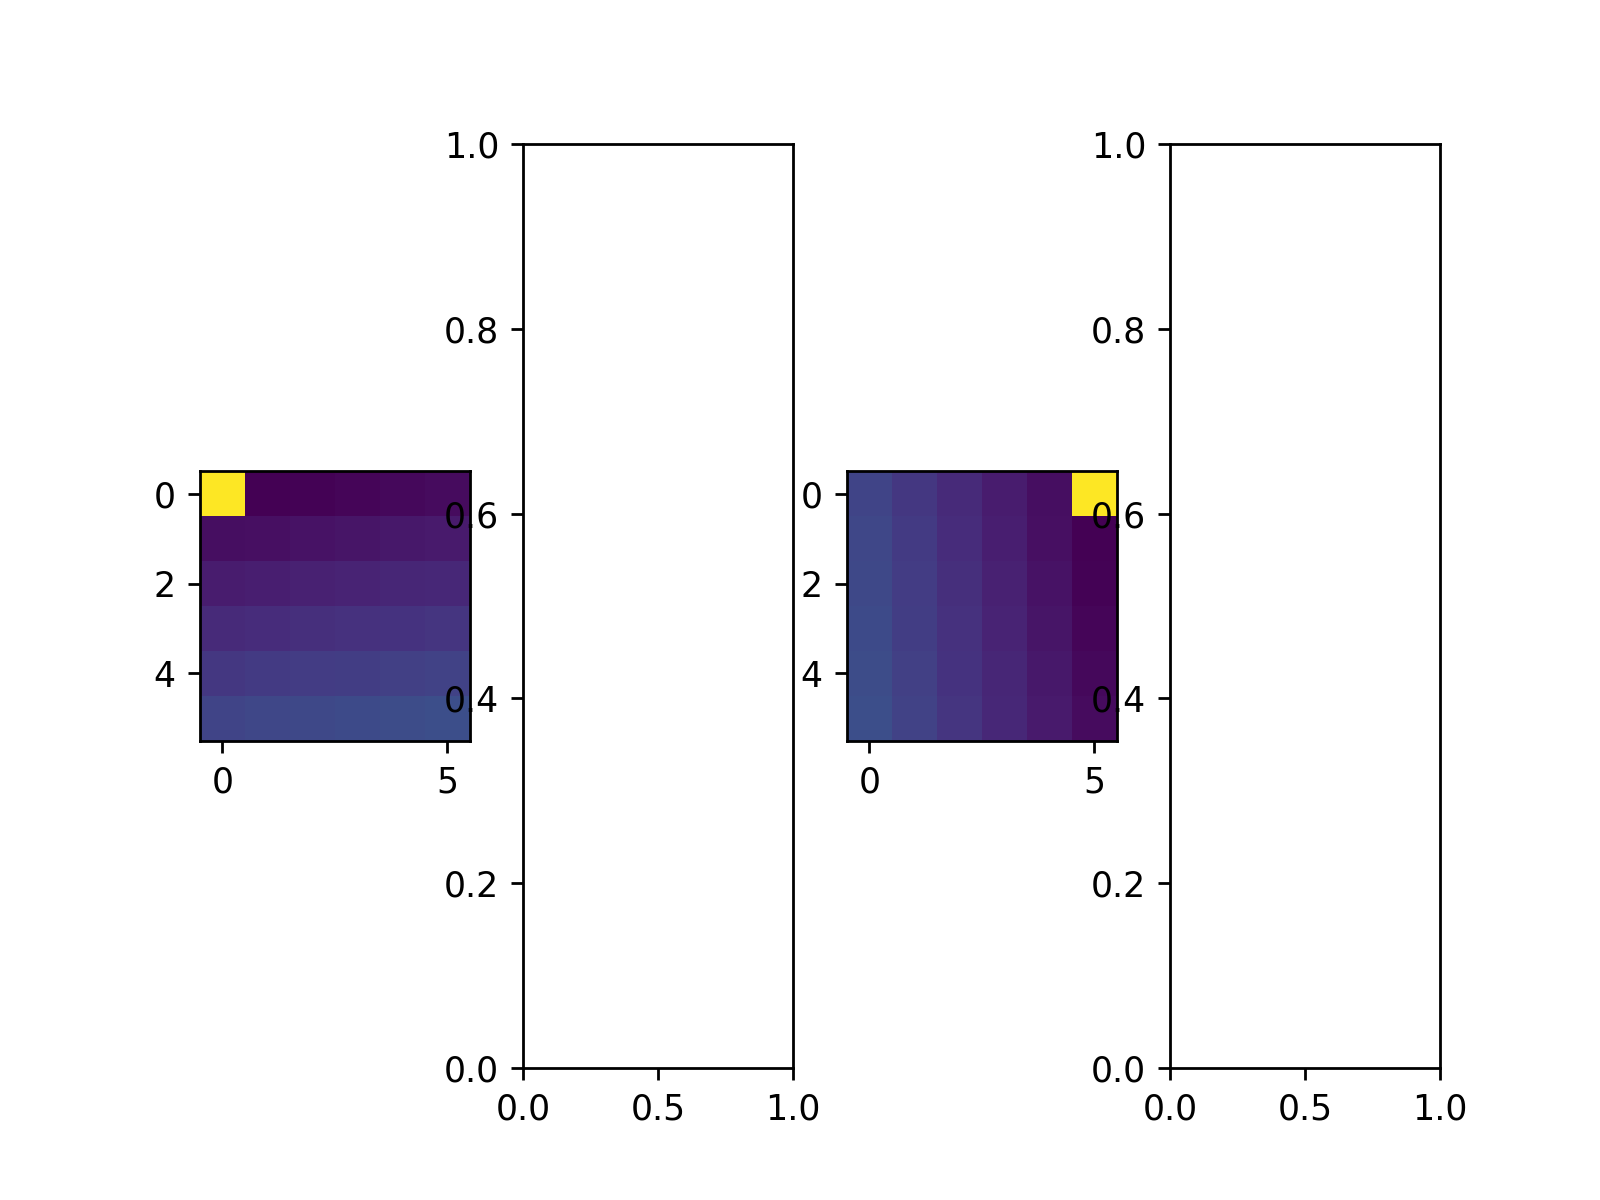

In [850]:
fig, axes = plt.subplots(1, 4)
axes[0].imshow(data[0, 0])
axes[2].imshow(res[0, 0])

In [851]:
lt_ctx = lt.Context(InlineJobExecutor())

In [852]:
ds = lt_ctx.load('memory', data=data, sig_dims=2)
transformed_ds = lt_ctx.load('memory', data=res, sig_dims=2)
com_a = lt_ctx.create_com_analysis(
    dataset=ds, mask_radius=np.inf, flip_y=False, scan_rotation=90.,
    cy=target_shape[0] / 2 - 0.5,
    cx=target_shape[1] / 2 - 0.5
)

com_res = lt_ctx.run(com_a)

trans_com_a = lt_ctx.create_com_analysis(
    dataset=transformed_ds, mask_radius=np.inf, flip_y=False, scan_rotation=0.,
    cy=target_shape[0] / 2 - 0.5,
    cx=target_shape[1] / 2 - 0.5
)
trans_com_res = lt_ctx.run(trans_com_a)

<IPython.core.display.Javascript object>


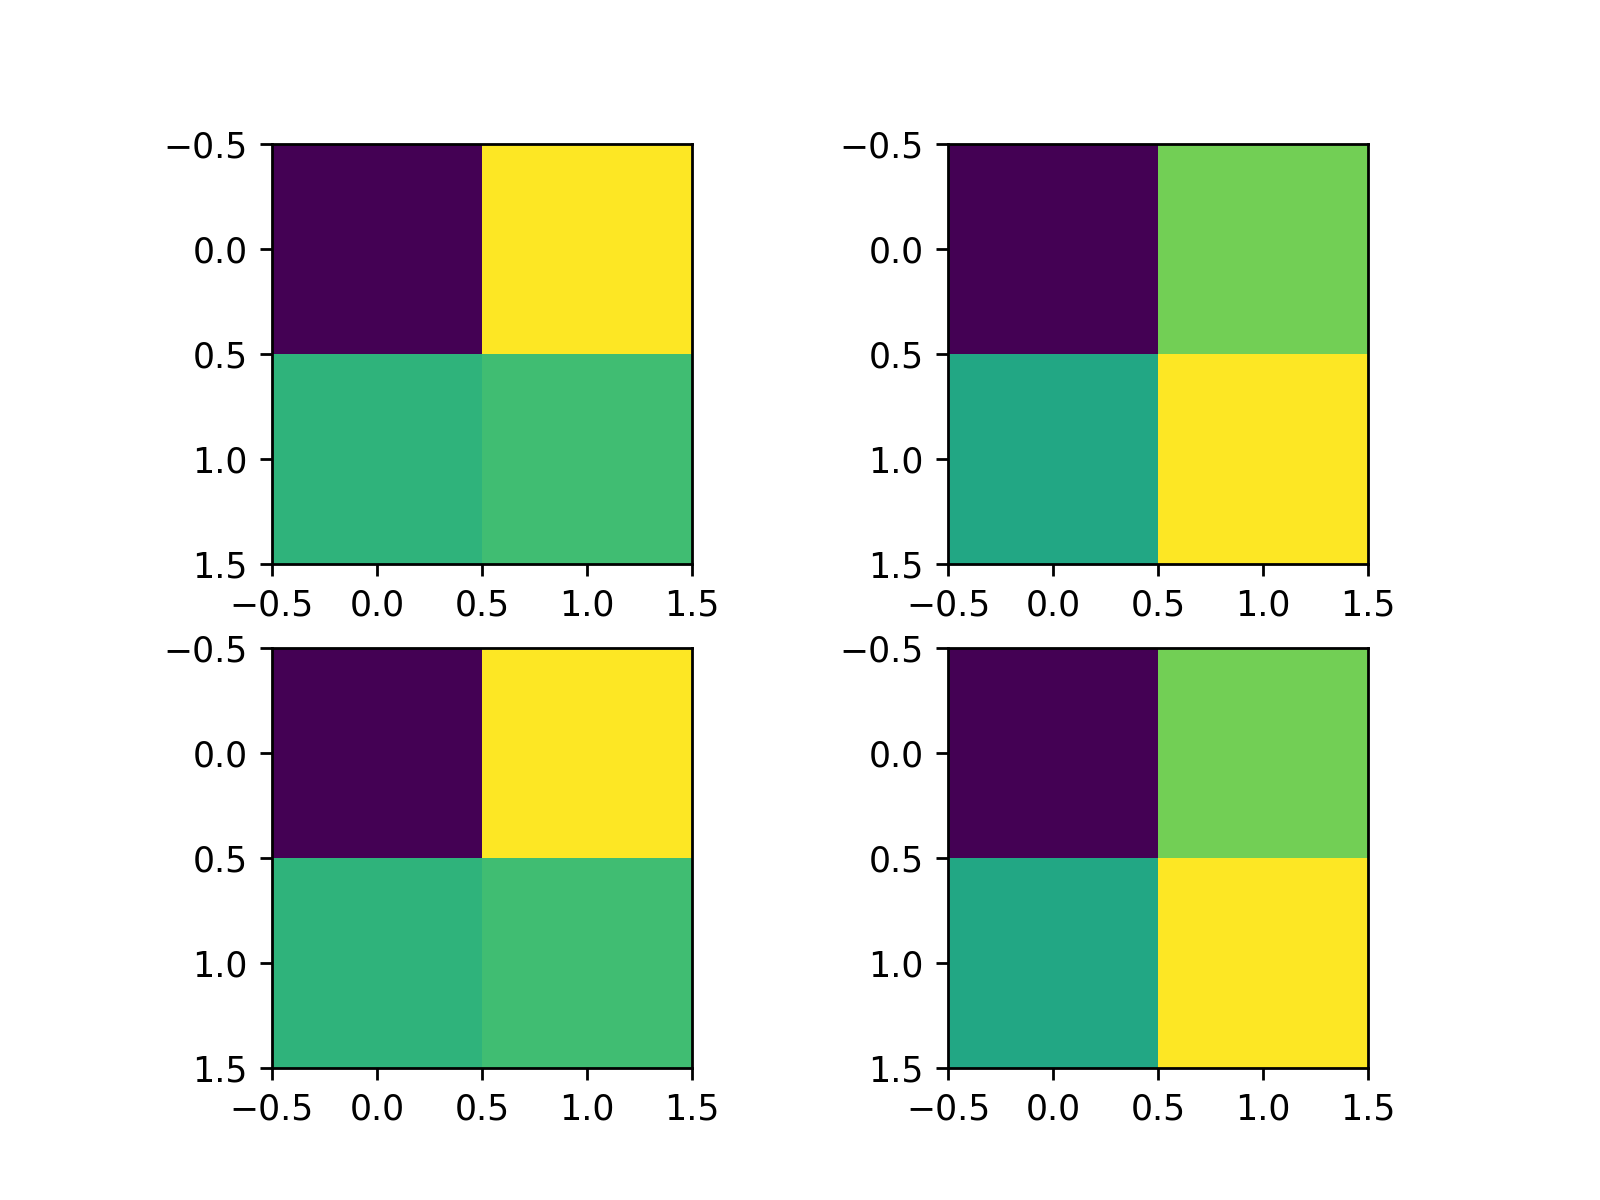

In [853]:
fig, axes = plt.subplots(2, 2)
axes[0, 0].imshow(com_res.y.raw_data)
axes[0, 1].imshow(com_res.x.raw_data)
axes[1, 0].imshow(trans_com_res.y.raw_data)
axes[1, 1].imshow(trans_com_res.x.raw_data)